In [ ]:
import pandas as pd

# Load the Excel sheet
file_path = '/workspaces/AND/ITU_regional_global_Key_ICT_indicator_aggregates_Nov_2024_by_urban-rural_area.xlsx'
df = pd.read_excel(file_path, sheet_name='By urban-rural area', header=None)

# Define the column ranges for each coverage area
zone_columns = {
    'Total': (1, 10),
    'Urban': (12, 21),
    'Rural': (23, 32)
}

# Identify the starting row of each indicator block
block_starts = [2 + 16 * i for i in range(5)]

# Extract and reshape each block into a tidy DataFrame
blocks = []
for start in block_starts:
    coverage_type = df.iloc[start, 0]
    for zone, (c_start, c_end) in zone_columns.items():
        # Read years
        years = df.iloc[start, c_start:c_end+1].tolist()
        years = [int(y) for y in years]
        
        # Read data rows
        data = df.iloc[start+1:start+15, [0] + list(range(c_start, c_end+1))].copy()
        data.columns = ['target'] + years
        
        # Melt to long format
        melted = data.melt(id_vars=['target'], var_name='year', value_name='coverage_value')
        melted['coverage_type'] = coverage_type
        melted['coverage_area'] = zone
        blocks.append(melted)

# Concatenate all blocks
df_final = pd.concat(blocks, ignore_index=True)

# Save to CSV
csv_path = 'dataset.csv'
df_final.to_csv(csv_path, index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Recharger le CSV après reset
df = pd.read_csv('dataset.csv')


In [ ]:
df.shape

On voit qu'il y a 2100 données et 5 attributs

In [ ]:
df.head()

In [ ]:
print("Informations générales :")
print()
df.info()

### Aperçu (head) et informations (info)
Le format attendu du dataset semble correct avec 4 colonnes (region, year, coverage_value, coverage_type, coverage_area). Cependant, il semble que la variable coverage_value contienne des données manquantes.

In [ ]:
print("Statistiques descriptives :")
df.describe()

### Interprétation analyse descriptive :
On ne remarque pas d'anomalies à première vue
- les années vont bien de 2015 à 2024
- toutes les couvertures sont bien entre 0 % et 100 %
<p>Il y a donc des couvertures totales (100%) et des couvertures absentes (0%) dans certaines zones ou région ou années pour certains types de couverture réseau.

In [ ]:
print("Valeurs manquantes par colonne :")
print(df.isna().sum(), "\n")

### Valeurs manquantes
On confirme que 462 valeurs de couverture sont manquantes. Nous allons donc procéder à un traitement de ces valeurs manquantes. Les valeurs manquantes concerne la couverture 5G et l'usage d'internet.

### Considérations à prendre en compte
Il est normal que la 5G n'ait aucune donnée avant 2020 car cette technologie n'était pas encore déployée. Nous allons donc imputer les valeurs manquantes par 0.

<p>Cependant, l'usage d'internet existe bel et bien depuis au moins 2015. Nous allons donc procéder à une interpolation pour imputer les valeurs manquantes.

In [ ]:
# Sélection des lignes correspondant à la couverture 5G
mask_5g = df['coverage_type'] == 'Population covered by at least a 5G mobile network (%)'

# Remplacement des NaN par 0 uniquement pour la 5G
df.loc[mask_5g, 'coverage_value'] = df.loc[mask_5g, 'coverage_value'].fillna(0)

# (Optionnel) Vérification
print(df.loc[mask_5g, ['target', 'year', 'coverage_value']].head(10))

df_5g = df[df['coverage_type']=="Population covered by at least a 5G mobile network (%)"]
df_5g.groupby('year')['coverage_value'].apply(lambda s: (s==0).sum()).plot(kind='bar')


<p>Les valeurs manquantes pour la 5G ont été remplacées par 0.
<p>Il faut encore traiter les valeurs de l'internet

In [ ]:
import pandas as pd

# 2. Sélection des données Internet
mask = df['coverage_type'] == 'Percentage of individuals using the Internet, by urban/rural area'
df_inet = df[mask].copy()

df_inet = df_inet.sort_values(['target','coverage_area','year'])

# 3. Interpolation linéaire par (pays ; zone)
df_inet['coverage_value'] = (
    df_inet
      .groupby(['target','coverage_area'])['coverage_value']
      .transform(lambda s: s.interpolate(method='linear', limit_direction='both'))
)

# 4. Remise dans le DataFrame d’origine
df.loc[mask, 'coverage_value'] = df_inet['coverage_value']


In [ ]:
print("Valeurs manquantes par colonne :")
print(df.isna().sum(), "\n")

Toutes les valeurs manquantes ont été traitées. Nous pouvons commencer quelques analyses préliminaires.

In [ ]:
df_pivot = df.pivot_table(
    index=['target','coverage_area','year'],
    columns='coverage_type',
    values='coverage_value'
)
corr_matrix = df_pivot.corr()

import seaborn as sns

# Matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation entre les séries")
plt.show()

# Matrice de corrélation pour les années à partir de 2020
pivot_2020 = df[df['year'] >= 2020].pivot_table(
    index=['target','coverage_area','year'],
    columns='coverage_type',
    values='coverage_value'
)
corr_matrix_2020 = pivot_2020.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_2020, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation entre les séries (années ≥ 2020)")
plt.show()

In [ ]:
# Histogramme de la distribution de 'coverage_value'
plt.figure()
df['coverage_value'].hist()
plt.title('Distribution de la couverture (%)')
plt.xlabel('Couverture (%)')
plt.ylabel('Nombre d\'observations')
plt.show()

# Histogramme de la distribution de 'coverage_value' pour les années à partir de 2020
plt.figure()
df[df['year'] >= 2020]['coverage_value'].hist()
plt.title("Distribution de la couverture (%) (années ≥ 2020)")
plt.xlabel('Couverture (%)')
plt.ylabel("Nombre d'observations")
plt.show()

In [ ]:
df_reg = df[
    (df["coverage_type"] == "Population covered by at least a 3G mobile network (%)")
    & (df["coverage_area"] == "Total")
].copy()
plt.hist(df_reg["coverage_value"], bins=20)
plt.title("Distribution de la couverture 3G (%)")
plt.xlabel("Coverage (%)")
plt.ylabel("Nombre d’observations")
plt.show()

In [ ]:
df_5g_all = df[
    (df["coverage_type"] == "Population covered by at least a 5G mobile network (%)")
    & (df["coverage_area"] == "Total")
].copy()
df_5g_2020 = df_5g_all[df_5g_all["year"] >= 2020]

import numpy as np

# Histogrammes côte à côte pour la couverture 5G (Total)
bins = np.histogram_bin_edges(
    np.concatenate([df_5g_all["coverage_value"], df_5g_2020["coverage_value"]]), bins=20
)
counts_all, _ = np.histogram(df_5g_all["coverage_value"], bins=bins)
counts_2020, _ = np.histogram(df_5g_2020["coverage_value"], bins=bins)
width = (bins[1] - bins[0]) * 0.4

centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(8,5))
plt.bar(centers - width/2, counts_all, width=width, label="2015-2024", align='center')
plt.bar(centers + width/2, counts_2020, width=width, label="2020-2024", align='center')
plt.title("Distribution de la couverture 5G (%) (Total)")
plt.xlabel("Coverage (%)")
plt.ylabel("Nombre d’observations")
plt.legend()
plt.show()

In [ ]:
# Boxplot de 'coverage_value' par 'zone'
plt.figure()
df.boxplot(column='coverage_value', by='coverage_area')
plt.title('Couverture (%) par type de zone de densité')
plt.suptitle('')
plt.xlabel('Type de densité')
plt.ylabel('Couverture (%)')
plt.show()

### Interprétation des résultats
#### Rural :
La médiane de couverture est plus basse (~45 %) que pour les autres types.
La dispersion est importante : la couverture varie beaucoup selon les régions/années.
#### Urban :
La médiane est nettement plus élevée (~80 %).
Les valeurs sont plus concentrées vers le haut, ce qui indique une meilleure couverture en zone urbaine.
#### Total :
La médiane est intermédiaire (~65 %), ce qui est logique car elle regroupe rural et urbain.
La dispersion est aussi intermédiaire.

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x="target", y="coverage_value", data=df)
plt.xticks(rotation=45)
plt.title("Distribution par région / groupe")
plt.show()

In [ ]:
mean_par_annee = df_reg.groupby("year")["coverage_value"].mean().reset_index()
plt.plot(mean_par_annee["year"], mean_par_annee["coverage_value"], marker='o')
plt.title("Tendance moyenne mondiale de la couverture 3G")
plt.xlabel("Année"); plt.ylabel("Coverage moyen (%)")
plt.show()

### Interprétation
<p>/!\ Attention au décalage de la légende /!\<p>

<p>Dans les pays les plus développés avec les plus hauts revenus la couverture est bien plus élevée et fréquent. (Europe, Amérique, High-income)
<p>Dans les pays émergents ou à revenus faibles voir modérés, la couverture est tout de même présente mais pour la plupart, ils ne sont quasiment qu'à moitié couverts. (Low-income, Islands, Least-Developed Countries)

## Analyse en Composantes Principales (ACP)
L'Analyse en Composantes Principales (ACP), ou PCA en anglais, est une méthode de réduction de dimensionnalité.
Elle transforme un jeu de données de variables corrélées en un nouveau jeu de composantes (axes principaux) non corrélées, ordonnées par la variance expliquée.
Les principales étapes sont :
1. **Standardisation** des données.
2. **Calcul** de la matrice de covariance.
3. **Décomposition en valeurs propres** (eigenvalues) et vecteurs propres (eigenvectors).
4. **Projection** des observations sur les axes principaux.

In [ ]:
# Pivot pour avoir une colonne par type de couverture
df_wide = df.pivot_table(
    index=['target', 'coverage_area', 'year'],
    columns='coverage_type',
    values='coverage_value'
).reset_index()

df_wide.head()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Variables quantitatives à inclure dans l'ACP
features = [
    'Population covered by a mobile-cellular network (%)',
    'Population covered by at least a 3G mobile network (%)',
    'Population covered by at least an LTE/WiMAX mobile network (%)',
    'Population covered by at least a 5G mobile network (%)',
    'Percentage of individuals using the Internet, by urban/rural area'
]

X = df_wide[features]

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print("composantes principales :")
print(pca.components_, "\n")
print("variances expliquées :")
print(pca.explained_variance_, "\n")
print("proportions des variances expliquées :")
print(pca.explained_variance_ratio_)
# Obtenir les proportions des variances expliquées cumulées
#explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Variance expliquée et cumulée
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

# Scree plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', label="Variance expliquée")
plt.plot(range(1, len(explained_var)+1), cum_var, marker='s', label="Variance expliquée cumulée")
plt.xticks(range(1, len(explained_var)+1))
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée par composante (ACP)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Contributions des variables aux composantes principales
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(features))],
    index=features
)

# Résultats principaux
{
    "variance_expliquee": explained_var.round(3).tolist(),
    "variance_expliquee_cumulee": cum_var.round(3).tolist(),
    "contributions_PC1": loadings['PC1'].round(3).sort_values(ascending=False).to_dict(),
    "contributions_PC2": loadings['PC2'].round(3).sort_values(ascending=False).to_dict(),
    "shape_pivot": X.shape
}

Variance expliquée par chaque composante principale
- PC1 : 70,7 % de la variance totale
- PC2 : 16,3 % (cumulé 86,9 %)
- PC3 : 8,4 %
- PC4 : 3,8 %
- PC5 : 0,9 %

<p>→ Les deux premiers axes résument près de 87 % de l’information !

### Contributions des variables à la première composante principale (PC1)
Plus la valeur absolue est grande, plus la variable "pèse" sur la composante.

| Variable                                                        | Contribution (PC1) |
|-----------------------------------------------------------------|--------------------|
| Population covered by at least a 3G mobile network (%)          | -0.503             |
| Population covered by at least an LTE/WiMAX mobile network (%)  | -0.502             |
| Population covered by a mobile-cellular network (%)             | -0.467             |
| Percentage of individuals using the Internet, by urban/rural area| -0.438             |
| Population covered by at least a 5G mobile network (%)          | -0.292             |

Lecture : PC1 synthétise le niveau global de couverture : plus une cible est “couverte” sur tous les plans, plus sa valeur sur PC1 est faible (négatif car tout est dans le même sens).

### Contributions des variables à la deuxième composante principale (PC2)
| Variable                                                          | Contribution (PC2) |
| ----------------------------------------------------------------- | ------------------ |
| Population covered by at least a 5G mobile network (%)            | +0.902             |
| Percentage of individuals using the Internet, by urban/rural area | +0.082             |
| Population covered by at least an LTE/WiMAX mobile network (%)    | -0.030             |
| Population covered by at least a 3G mobile network (%)            | -0.244             |
| Population covered by a mobile-cellular network (%)               | -0.346             |

Lecture : PC2 oppose fortement la 5G aux autres formes de couverture, ce qui traduit un axe d’évolution technologique.

In [ ]:
# 1. Import des bibliothèques nécessaires pour la PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Préparation des données : pivot avec un feature par type de couverture
# On réutilise df_pivot défini précédemment : index=(target, coverage_area, year), colonnes=coverage_type
# Suppression des lignes avec NaN pour assurer une ACP sans valeurs manquantes
df_pca = df_pivot.dropna()

# 3. Standardisation des variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca.values)

# 4. Calcul de la PCA
pca = PCA()
principalComponents = pca.fit_transform(X_scaled)

# 5. Variance expliquée par chaque composante
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)
print("Variance expliquée par composante :", np.round(explained_var, 3))
print("Variance cumulative :", np.round(cum_var, 3))

In [ ]:
# 6. Scree plot (diagramme des éboulis)
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_var)+1), explained_var, alpha=0.7, label='Individuelle')
plt.step(range(1, len(cum_var)+1), cum_var, where='mid', label='Cumulative', color='red')
plt.xlabel('Composante Principale')
plt.ylabel('Variance expliquée')
plt.title('Scree Plot - ACP')
plt.legend()
plt.show()

### Interprétation du Scree Plot
- Les premières composantes expliquent la majeure partie de la variance.
- Le « coude » dans le diagramme peut aider à choisir le nombre optimal de composantes à retenir.

In [ ]:
# 7. Projection des données sur les deux premières composantes principales
pc_df = pd.DataFrame(principalComponents[:, :2],
                     columns=['PC1', 'PC2'],
                     index=df_pca.index)

plt.figure(figsize=(10, 8))
# Coloration par type de zone
sns.scatterplot(x='PC1', y='PC2', data=pc_df.join(pd.Series([idx[1] for idx in df_pca.index],
                                                             index=df_pca.index,
                                                             name='coverage_area')),
                hue='coverage_area', alpha=0.7)
plt.title('Projection sur PC1 et PC2')
plt.xlabel(f"PC1 (6.2f% de variance)" % (explained_var[0]*100))
plt.ylabel(f"PC2 (6.2f% de variance)" % (explained_var[1]*100))
plt.legend()
plt.show()

In [ ]:
# Pivot pour avoir une colonne par type de couverture
df_wide = df.pivot_table(
    index=['target', 'coverage_area', 'year'],
    columns='coverage_type',
    values='coverage_value'
).reset_index()

# Variables quantitatives à inclure dans l'ACP (exclure 5G et Internet)
features = [
    'Population covered by a mobile-cellular network (%)',
    'Population covered by at least a 3G mobile network (%)',
    'Population covered by at least an LTE/WiMAX mobile network (%)'
]

X = df_wide[features].fillna(0)

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée et cumulée
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

# Scree plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', label="Variance expliquée")
plt.plot(range(1, len(explained_var)+1), cum_var, marker='s', label="Variance expliquée cumulée")
plt.xticks(range(1, len(explained_var)+1))
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée')
plt.title('ACP 2015-2024 sans 5G ni Internet: variance expliquée')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Contributions des variables
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(features))],
    index=features
)

# Résultats
results = {
    "variance_expliquee": explained_var.round(3).tolist(),
    "variance_expliquee_cumulee": cum_var.round(3).tolist(),
    "contributions_PC1": loadings['PC1'].round(3).sort_values(ascending=False).to_dict(),
    "contributions_PC2": loadings['PC2'].round(3).sort_values(ascending=False).to_dict(),
    "shape": X.shape
}

results

In [ ]:
# Pivot pour avoir une colonne par type de couverture
df_wide = df.pivot_table(
    index=['target', 'coverage_area', 'year'],
    columns='coverage_type',
    values='coverage_value'
).reset_index()

# Filtrer sur les années 2021 à 2024
df_subset = df_wide[df_wide['year'].between(2021, 2024)]

# Variables quantitatives à inclure dans l'ACP
features = [
    'Population covered by a mobile-cellular network (%)',
    'Population covered by at least a 3G mobile network (%)',
    'Population covered by at least an LTE/WiMAX mobile network (%)',
    'Population covered by at least a 5G mobile network (%)',
    'Percentage of individuals using the Internet, by urban/rural area'
]

X = df_subset[features].fillna(0)

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée et cumulée
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

# Scree plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', label="Variance expliquée")
plt.plot(range(1, len(explained_var)+1), cum_var, marker='s', label="Variance expliquée cumulée")
plt.xticks(range(1, len(explained_var)+1))
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée')
plt.title('ACP sur 2021-2024 : variance expliquée par composante')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Contributions des variables aux composantes principales
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(features))],
    index=features
)

# Résultats principaux
results = {
    "variance_expliquee": explained_var.round(3).tolist(),
    "variance_expliquee_cumulee": cum_var.round(3).tolist(),
    "contributions_PC1": loadings['PC1'].round(3).sort_values(ascending=False).to_dict(),
    "contributions_PC2": loadings['PC2'].round(3).sort_values(ascending=False).to_dict(),
    "shape_subset": X.shape
}

results

In [ ]:
df_wide = df.pivot_table(
    index=['target', 'coverage_area', 'year'],
    columns='coverage_type',
    values='coverage_value'
).reset_index()

features = [
    'Population covered by a mobile-cellular network (%)',
    'Population covered by at least a 3G mobile network (%)',
    'Population covered by at least an LTE/WiMAX mobile network (%)',
    'Population covered by at least a 5G mobile network (%)',
    'Percentage of individuals using the Internet, by urban/rural area'
]
X = df_wide[features].fillna(0)

# Standardisation et PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Couleurs par zone de couverture
zones = df_wide['coverage_area'].unique()
colors = ['tab:blue', 'tab:orange', 'tab:green']
color_map = dict(zip(zones, colors))

plt.figure(figsize=(8, 6))
for zone in zones:
    idx = df_wide['coverage_area'] == zone
    plt.scatter(
        X_pca[idx, 0], X_pca[idx, 1],
        c=color_map[zone], label=zone, alpha=0.7, edgecolors='w', s=60
    )

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('Projection PCA colorée par zone de couverture')
plt.legend(title="Zone de couverture")
plt.grid()
plt.tight_layout()
plt.show()

import matplotlib.cm as cm

years = sorted(df_wide['year'].unique())
cmap = cm.get_cmap('viridis', len(years))
norm = plt.Normalize(min(years), max(years))

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df_wide['year'], cmap=cmap, norm=norm, alpha=0.8, s=60, edgecolors='k'
)
plt.colorbar(sc, label="Année")
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('Projection PCA colorée par année')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Cell 31 : PCA étape par étape selon le cours

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Sélection des variables quantitatives
features = [
    'Population covered by a mobile-cellular network (%)',
    'Population covered by at least a 3G mobile network (%)',
    'Population covered by at least an LTE/WiMAX mobile network (%)',
    'Population covered by at least a 5G mobile network (%)',
    'Percentage of individuals using the Internet, by urban/rural area'
]
X = df_wide[features].fillna(0)

# 2. Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Créer le modèle PCA (2 composantes principales)
pca = PCA(n_components=2)

# 4. Appliquer la PCA à la base de données
pca.fit(X_scaled)

# 5. Projeter les données
X_pca = pca.transform(X_scaled)

# 6. Obtenir les composantes principales
print("Composantes principales (axes) :\n", pca.components_)

# 7. Obtenir les variances expliquées
print("Variances expliquées :", pca.explained_variance_)

# 8. Obtenir les proportions des variances expliquées
print("Proportions des variances expliquées :", pca.explained_variance_ratio_)

# 9. Obtenir les proportions cumulées
explained_var_cum = np.cumsum(pca.explained_variance_) / np.sum(pca.explained_variance_)
print("Proportions cumulées :", explained_var_cum)

# 10. Re-projeter dans le repère d'origine
X_new = pca.inverse_transform(X_pca)

In [ ]:
# 4. Modélisation supervisée 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Optionnel : XGBoost si installé
try:
    import xgboost as xgb
    has_xgb = True
except ImportError:
    has_xgb = False
    print("xgboost non installé, XGBoost sera ignoré.")

# Préparation des données
features = [
    'Population covered by a mobile-cellular network (%)',
    'Population covered by at least a 3G mobile network (%)',
    'Population covered by at least an LTE/WiMAX mobile network (%)',
    'Population covered by at least a 5G mobile network (%)'
]
X = df_wide[features].copy()
y = df_wide['Percentage of individuals using the Internet, by urban/rural area']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Définition des modèles
models = {
    'SVR': SVR(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42)
}
if has_xgb:
    models['XGBoost'] = xgb.XGBRegressor(random_state=42, verbosity=0)

# Entraînement initial et scores
print("Scores R² AVANT tuning :")
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name:12s} | R² train: {model.score(X_train, y_train):.3f} | test: {model.score(X_test, y_test):.3f}")

# Grilles d'hyperparamètres
param_grid = {
    'SVR': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']},
    'DecisionTree': {'max_depth': [3, 5, 7]},
    'RandomForest': {'n_estimators': [50, 100], 'max_depth': [5, 10]},
}
if has_xgb:
    param_grid['XGBoost'] = {'n_estimators': [50, 100], 'max_depth': [3, 5]}

# GridSearchCV pour chaque modèle
best_models = {}
print("\nTuning des hyperparamètres (GridSearchCV) :")
for name, model in models.items():
    grid = GridSearchCV(model, param_grid[name], cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"{name:12s} | best params: {grid.best_params_} | best CV R²: {grid.best_score_:.3f}")

# Scores après tuning
print("\nScores R² APRÈS tuning :")
for name, model in best_models.items():
    r2_train = model.score(X_train, y_train)
    r2_test = model.score(X_test, y_test)
    print(f"{name:12s} | R² train: {r2_train:.3f} | test: {r2_test:.3f}")

Scores R² AVANT tuning :
SVR          | R² train: 0.548 | test: 0.512
DecisionTree | R² train: 1.000 | test: 0.661
RandomForest | R² train: 0.958 | test: 0.754
XGBoost      | R² train: 1.000 | test: 0.782

Tuning des hyperparamètres (GridSearchCV) :
SVR          | best params: {'C': 10, 'kernel': 'rbf'} | best CV R²: 0.537
DecisionTree | best params: {'max_depth': 5} | best CV R²: 0.577
RandomForest | best params: {'max_depth': 10, 'n_estimators': 100} | best CV R²: 0.659
XGBoost      | best params: {'max_depth': 3, 'n_estimators': 50} | best CV R²: 0.619

Scores R² APRÈS tuning :
SVR          | R² train: 0.553 | test: 0.526
DecisionTree | R² train: 0.777 | test: 0.635
RandomForest | R² train: 0.953 | test: 0.752
XGBoost      | R² train: 0.919 | test: 0.728


Quelques prédictions vs vraies valeurs :
Prédiction : 89.39 | Réel : 88.20
Prédiction : 42.53 | Réel : 38.40
Prédiction : 92.61 | Réel : 89.50
Prédiction : 69.10 | Réel : 69.10
Prédiction : 66.00 | Réel : 76.70
Prédiction : 66.45 | Réel : 64.70
Prédiction : 59.45 | Réel : 84.20
Prédiction : 80.83 | Réel : 87.00
Prédiction : 36.69 | Réel : 69.50
Prédiction : 63.01 | Réel : 64.70


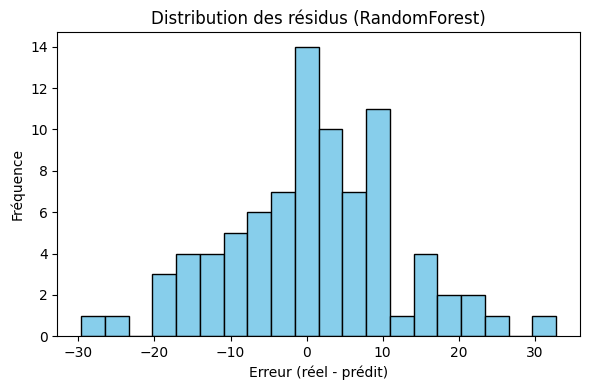

Erreur moyenne absolue : 8.647
Erreur quadratique moyenne : 11.240

Feature la plus importante selon RandomForest : Population covered by at least an LTE/WiMAX mobile network (%)
R² test après retrait de 'Population covered by at least an LTE/WiMAX mobile network (%)' : 0.627 (avant : 0.752)


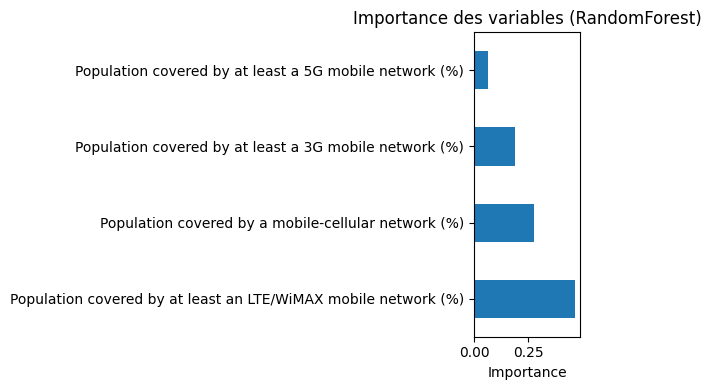


Analyse des features :
- Population covered by at least an LTE/WiMAX mobile network (%) : importance = 0.468
- Population covered by a mobile-cellular network (%)     : importance = 0.277
- Population covered by at least a 3G mobile network (%)  : importance = 0.191
- Population covered by at least a 5G mobile network (%)  : importance = 0.064

Conclusion :
La variable la plus influente est 'Population covered by at least an LTE/WiMAX mobile network (%)'. Son retrait fait baisser le score R² de 0.752 à 0.627.
Les variables de couverture réseau (3G, LTE/WiMAX, etc.) expliquent très bien l'usage d'internet, ce qui est cohérent avec la logique métier.


In [69]:
# 1. Afficher quelques prédictions vs vraies valeurs (RandomForest)
rf = best_models['RandomForest']
y_pred = rf.predict(X_test)
print("Quelques prédictions vs vraies valeurs :")
for i in range(10):
    print(f"Prédiction : {y_pred[i]:.2f} | Réel : {y_test.iloc[i]:.2f}")

# 2. Distribution des résidus (erreurs)
residus = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residus, bins=20, color='skyblue', edgecolor='k')
plt.title("Distribution des résidus (RandomForest)")
plt.xlabel("Erreur (réel - prédit)")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()
print(f"Erreur moyenne absolue : {np.abs(residus).mean():.3f}")
print(f"Erreur quadratique moyenne : {np.sqrt((residus**2).mean()):.3f}")

# 3. Retirer la feature la plus importante et voir l'impact sur le score
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
feature_to_remove = importances.index[0]
print(f"\nFeature la plus importante selon RandomForest : {feature_to_remove}")

features_reduced = [f for f in features if f != feature_to_remove]
X_train_red = X_train[features_reduced]
X_test_red = X_test[features_reduced]

rf_reduced = RandomForestRegressor(random_state=42, n_estimators=rf.n_estimators, max_depth=rf.max_depth)
rf_reduced.fit(X_train_red, y_train)
r2_reduced = rf_reduced.score(X_test_red, y_test)
print(f"R² test après retrait de '{feature_to_remove}' : {r2_reduced:.3f} (avant : {rf.score(X_test, y_test):.3f})")

# 4. Analyse des features (importances)
plt.figure(figsize=(6,4))
importances.plot(kind='barh')
plt.title("Importance des variables (RandomForest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

print("\nAnalyse des features :")
for feat, imp in importances.items():
    print(f"- {feat:55s} : importance = {imp:.3f}")

print("\nConclusion :")
print(f"La variable la plus influente est '{feature_to_remove}'. Son retrait fait baisser le score R² de {rf.score(X_test, y_test):.3f} à {r2_reduced:.3f}.")
print("Les variables de couverture réseau (3G, LTE/WiMAX, etc.) expliquent très bien l'usage d'internet, ce qui est cohérent avec la logique métier.")

SVR non-tuné → MSE = 87.736, R² = 0.229, MAE = 7.747


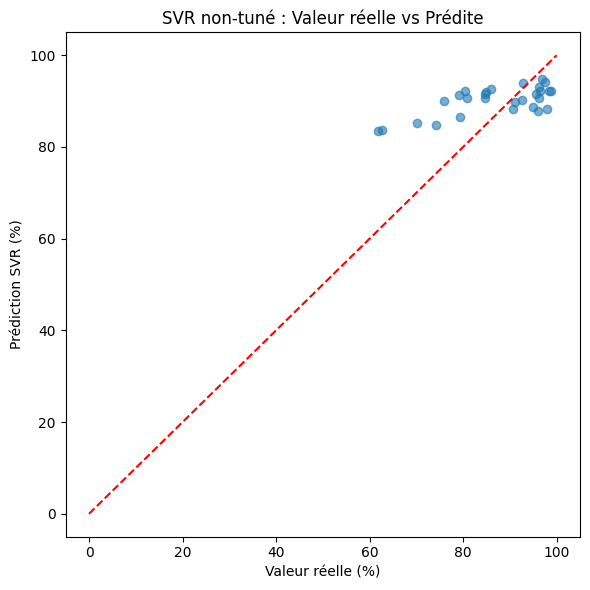

Meilleurs paramètres SVR : {'C': 100, 'epsilon': 0.01, 'kernel': 'rbf'}
SVR tuné → MSE = 2.566, R² = 0.977, MAE = 1.245
SVC non-tuné → Accuracy = 0.929, F1 = 0.952, AUC-ROC = 1.000
Matrice de confusion (non-tuné) :
 [[ 6  2]
 [ 0 20]]
Rapport classification (non-tuné) :
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.91      1.00      0.95        20

    accuracy                           0.93        28
   macro avg       0.95      0.88      0.90        28
weighted avg       0.94      0.93      0.93        28



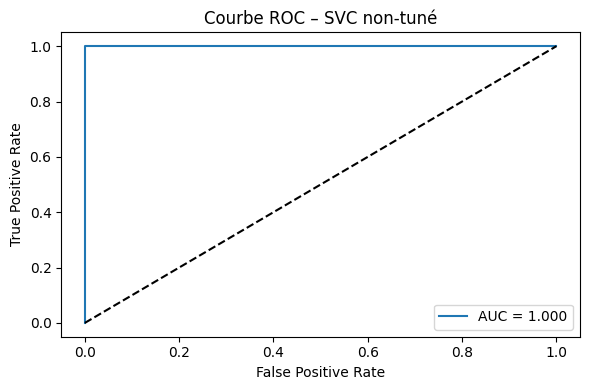

Meilleurs paramètres SVC : {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
SVC tuné → Accuracy = 1.000, F1 = 1.000, AUC-ROC = 1.000
Matrice de confusion (tuné) :
 [[ 8  0]
 [ 0 20]]
Rapport classification (tuné) :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        20

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



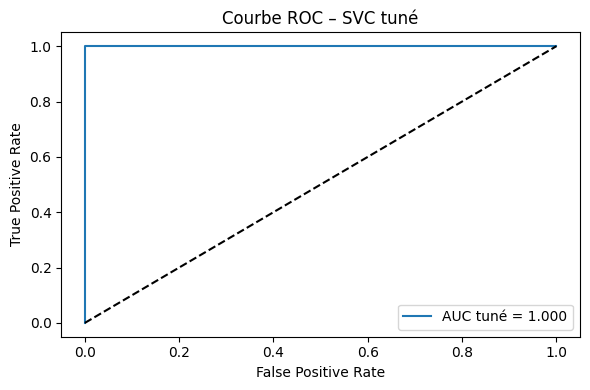

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR, SVC
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report, roc_curve
)

# Filtrer sur "coverage_type" = "Population covered by at least a 3G mobile network (%)"
# et "coverage_area" = "Total"
mask_3g = (
    (df["coverage_type"] == "Population covered by at least a 3G mobile network (%)")
    & (df["coverage_area"] == "Total")
)
df_3g = df.loc[mask_3g].copy()

# ---------------------------------------------------------------------------
# Préparation des features (X) et de la cible continue (y_reg) pour SVR
# ---------------------------------------------------------------------------
# 1) Encodage OneHot de la variable catégorielle 'target'
ohe_target = OneHotEncoder(sparse_output=False, drop="first")
X_target_ohe = ohe_target.fit_transform(df_3g[["target"]])
feature_names_target = ohe_target.get_feature_names_out(["target"])

# 2) Standardisation de la variable 'year'
scaler_year = StandardScaler()
X_year_scaled = scaler_year.fit_transform(df_3g[["year"]])

# 3) Assemblage des features pour le modèle (SVR/SVC)
X = np.hstack([X_year_scaled, X_target_ohe])
feature_names = ["year_scaled"] + list(feature_names_target)

# 4) Définir la cible pour la RÉGRESSION (coverage_value)
y_reg = df_3g["coverage_value"].values

# ---------------------------------------------------------------------------
# Séparation en train / test pour la régression
# ---------------------------------------------------------------------------
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

# ---------------------------------------------------------------------------
# Entraînement SVR de base (non tuné)
# ---------------------------------------------------------------------------
svr = SVR(kernel="rbf", C=1.0, epsilon=0.1)
svr.fit(X_train_reg, y_train_reg)

y_pred_reg = svr.predict(X_test_reg)

mse_init = mean_squared_error(y_test_reg, y_pred_reg)
r2_init = r2_score(y_test_reg, y_pred_reg)
mae_init = mean_absolute_error(y_test_reg, y_pred_reg)
print(f"SVR non-tuné → MSE = {mse_init:.3f}, R² = {r2_init:.3f}, MAE = {mae_init:.3f}")

# Visualisation : valeurs réelles vs prédites
plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.6)
plt.plot([0, 100], [0, 100], color="red", linestyle="--")
plt.xlabel("Valeur réelle (%)")
plt.ylabel("Prédiction SVR (%)")
plt.title("SVR non-tuné : Valeur réelle vs Prédite")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# GridSearchCV pour tuner le SVR
# ---------------------------------------------------------------------------
param_grid_svr = {
    "kernel": ["rbf", "linear"],
    "C": [0.1, 1, 10, 100],
    "epsilon": [0.01, 0.1, 0.2, 0.5]
}

grid_svr = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid_svr,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)
grid_svr.fit(X_train_reg, y_train_reg)

print("Meilleurs paramètres SVR :", grid_svr.best_params_)
best_svr = grid_svr.best_estimator_

# Évaluation du SVR tuné
y_pred_tuned_reg = best_svr.predict(X_test_reg)

mse_tuned = mean_squared_error(y_test_reg, y_pred_tuned_reg)
r2_tuned = r2_score(y_test_reg, y_pred_tuned_reg)
mae_tuned = mean_absolute_error(y_test_reg, y_pred_tuned_reg)
print(f"SVR tuné → MSE = {mse_tuned:.3f}, R² = {r2_tuned:.3f}, MAE = {mae_tuned:.3f}")

# ---------------------------------------------------------------------------
# Préparation de la cible pour la classification (SVC)
# ---------------------------------------------------------------------------
# Création d'une variable binaire : 1 si coverage_value >= 80%, 0 sinon
seuil = 80
df_3g["coverage_binary"] = (df_3g["coverage_value"] >= seuil).astype(int)

y_cls = df_3g["coverage_binary"].values

# ---------------------------------------------------------------------------
# Séparation train/test pour la classification (stratifié)
# ---------------------------------------------------------------------------
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# ---------------------------------------------------------------------------
# Entraînement SVC de base (non tuné)
# ---------------------------------------------------------------------------
svc = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True)
svc.fit(X_train_cls, y_train_cls)

y_pred_cls = svc.predict(X_test_cls)
y_score_cls = svc.predict_proba(X_test_cls)[:, 1]

acc_init = accuracy_score(y_test_cls, y_pred_cls)
f1_init = f1_score(y_test_cls, y_pred_cls)
auc_init = roc_auc_score(y_test_cls, y_score_cls)
cm_init = confusion_matrix(y_test_cls, y_pred_cls)

print(f"SVC non-tuné → Accuracy = {acc_init:.3f}, F1 = {f1_init:.3f}, AUC-ROC = {auc_init:.3f}")
print("Matrice de confusion (non-tuné) :\n", cm_init)
print("Rapport classification (non-tuné) :\n", classification_report(y_test_cls, y_pred_cls))

# Courbe ROC pour le SVC non tuné
fpr, tpr, _ = roc_curve(y_test_cls, y_score_cls)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_init:.3f}")
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC – SVC non-tuné")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# GridSearchCV pour tuner le SVC
# ---------------------------------------------------------------------------
param_grid_svc = {
    "kernel": ["rbf", "linear"],
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto"]
}

grid_svc = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=param_grid_svc,
    scoring="f1",
    cv=5,
    n_jobs=-1
)
grid_svc.fit(X_train_cls, y_train_cls)

print("Meilleurs paramètres SVC :", grid_svc.best_params_)
best_svc = grid_svc.best_estimator_

# Évaluation du SVC tuné
y_pred_tuned_cls = best_svc.predict(X_test_cls)
y_score_tuned_cls = best_svc.predict_proba(X_test_cls)[:, 1]

acc_tuned = accuracy_score(y_test_cls, y_pred_tuned_cls)
f1_tuned = f1_score(y_test_cls, y_pred_tuned_cls)
auc_tuned = roc_auc_score(y_test_cls, y_score_tuned_cls)
cm_tuned = confusion_matrix(y_test_cls, y_pred_tuned_cls)

print(f"SVC tuné → Accuracy = {acc_tuned:.3f}, F1 = {f1_tuned:.3f}, AUC-ROC = {auc_tuned:.3f}")
print("Matrice de confusion (tuné) :\n", cm_tuned)
print("Rapport classification (tuné) :\n", classification_report(y_test_cls, y_pred_tuned_cls))

# Courbe ROC pour le SVC tuné
fpr_t, tpr_t, _ = roc_curve(y_test_cls, y_score_tuned_cls)
plt.figure(figsize=(6, 4))
plt.plot(fpr_t, tpr_t, label=f"AUC tuné = {auc_tuned:.3f}")
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC – SVC tuné")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Fin du script
# ---------------------------------------------------------------------------


SVR simple → MSE = 9.231, R² = 0.919


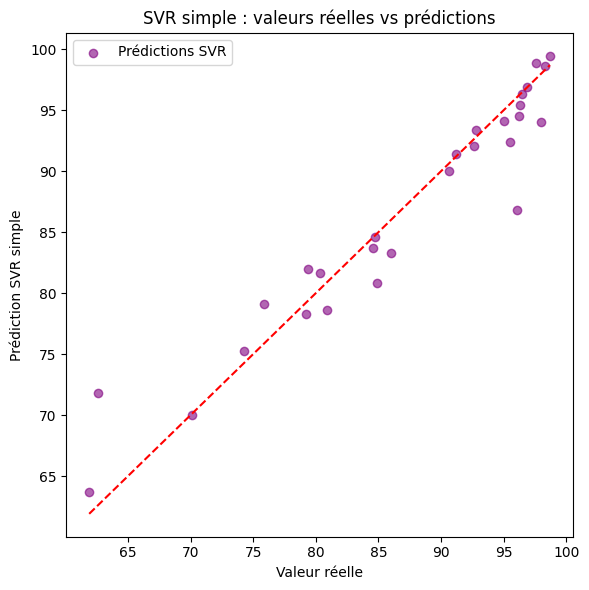

In [73]:
# Cell 43: SVR simple de régression
from sklearn.svm import SVR

# Définir et entraîner le modèle SVR
svr_simple = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_simple.fit(X_train_reg, y_train_reg)

# Prédiction et évaluation
y_pred_simple = svr_simple.predict(X_test_reg)
mse_simple = mean_squared_error(y_test_reg, y_pred_simple)
r2_simple = r2_score(y_test_reg, y_pred_simple)
print(f"SVR simple → MSE = {mse_simple:.3f}, R² = {r2_simple:.3f}")

# Visualisation : valeurs réelles vs prédictions
plt.figure(figsize=(6,6))
plt.scatter(y_test_reg, y_pred_simple, color='purple', alpha=0.6, label='Prédictions SVR')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], color='red', linestyle='--')
plt.xlabel("Valeur réelle")
plt.ylabel("Prédiction SVR simple")
plt.title("SVR simple : valeurs réelles vs prédictions")
plt.legend()
plt.tight_layout()
plt.show()